In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
accident = pd.read_csv('dft-accident.csv')

/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (0,2,35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
accident

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,2019010128300,2019,10128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,...,5,1,1,1,0,0,1,3,2,E01004762
1,2019010152270,2019,10152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,...,9,4,1,1,0,0,1,3,2,E01003117
2,2019010155191,2019,10155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,...,0,4,1,1,0,0,1,1,2,E01000943
3,2019010155192,2019,10155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,...,0,4,1,1,0,0,1,1,2,E01000973
4,2019010155194,2019,10155194,524920.0,184004.0,-0.200064,51.541121,1,3,2,...,0,4,1,1,0,0,1,1,2,E01000546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117531,2019984106919,2019,984106919,312635.0,573392.0,-3.368899,55.047323,98,3,1,...,0,1,1,2,0,0,2,1,-1,-1
117532,2019984107019,2019,984107019,337522.0,591682.0,-2.983499,55.215407,98,3,4,...,0,1,1,2,0,0,2,1,-1,-1
117533,2019984107219,2019,984107219,318544.0,567087.0,-3.274645,54.991685,98,3,2,...,0,1,1,1,0,0,2,2,-1,-1
117534,2019984107419,2019,984107419,336525.0,584226.0,-2.997491,55.148292,98,3,1,...,0,1,1,1,0,0,2,2,-1,-1


In [15]:
list(accident.columns.values)

['accident_index',
 'accident_year',
 'accident_reference',
 'location_easting_osgr',
 'location_northing_osgr',
 'longitude',
 'latitude',
 'police_force',
 'accident_severity',
 'number_of_vehicles',
 'number_of_casualties',
 'date',
 'day_of_week',
 'time',
 'local_authority_district',
 'local_authority_ons_district',
 'local_authority_highway',
 'first_road_class',
 'first_road_number',
 'road_type',
 'speed_limit',
 'junction_detail',
 'junction_control',
 'second_road_class',
 'second_road_number',
 'pedestrian_crossing_human_control',
 'pedestrian_crossing_physical_facilities',
 'light_conditions',
 'weather_conditions',
 'road_surface_conditions',
 'special_conditions_at_site',
 'carriageway_hazards',
 'urban_or_rural_area',
 'did_police_officer_attend_scene_of_accident',
 'trunk_road_flag',
 'lsoa_of_accident_location']

In [16]:
accident.dtypes

accident_index                                  object
accident_year                                    int64
accident_reference                              object
location_easting_osgr                          float64
location_northing_osgr                         float64
longitude                                      float64
latitude                                       float64
police_force                                     int64
accident_severity                                int64
number_of_vehicles                               int64
number_of_casualties                             int64
date                                            object
day_of_week                                      int64
time                                            object
local_authority_district                         int64
local_authority_ons_district                    object
local_authority_highway                         object
first_road_class                                 int64
first_road

In [17]:
date = accident['date'].str.split('/', expand=True)
accident['date'] = date[1]
accident['date']

0         02
1         01
2         01
3         01
4         01
          ..
117531    05
117532    05
117533    06
117534    06
117535    04
Name: date, Length: 117536, dtype: object

(array([18209.,  8899.,  9942.,  9427.,  9758., 10325.,  9534., 10311.,
        10222., 20909.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

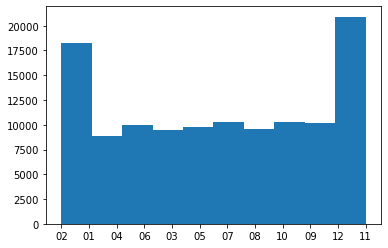

In [19]:
plt.hist(accident['date'])